# Bees vs Wasps notebook

In [ ]:
!git clone https://github.com/Patricklomp/AI-course-project.git


fatal: destination path 'AI-course-project' already exists and is not an empty directory.


Andmete URL: https://www.kaggle.com/jerzydziewierz/bee-vs-wasp#

#### Kasutatud materjal
- https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
- https://www.kaggle.com/koshirosato/bee-or-wasp-base-line-using-resnet50/notebook

#### Grupp
- Patrick Lomp
- Artti Raasuke

#### Impordid

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# additional classic imports
from pathlib import Path
import pandas as pd
import numpy as np
import random
import os
import gc
import cv2
from google.colab.patches import cv2_imshow

from tensorflow.keras.layers import *
from keras.models import Sequential
from keras.optimizers import Adam
from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# pip3 install --upgrade tensorflow-gpu

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13616495685560305265
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15692777408
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12329672552923750403
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


#### Parameetrid

In [ ]:
bs = 64 # Batch size
resize_size = 96 # for training, resize all the images to a square of this size
training_subsample = 0.1 # for development, use a small fraction of the entire dataset rater than full dataset
ROOT = './AI-course-project/data'
IMG_SIZE = 256
EPOCHS = 50

## Andmestikude loomine




In [ ]:
bees_vs_wasps_dataset_path=Path(ROOT) # this is relative to the "example_notebook" folder. Modify this to reflect your setup
df_labels = pd.read_csv(bees_vs_wasps_dataset_path/'labels.csv')
df_labels=df_labels.set_index('id')
# perform dataset subsampling
df_labels = df_labels.sample(frac=training_subsample, axis=0)

In [ ]:
for idx in tqdm(df_labels.index):    
    df_labels.loc[idx,'path']=df_labels.loc[idx,'path'].replace('\\', '/') 
    
df_labels.head()

100%|██████████| 1142/1142 [00:00<00:00, 1869.08it/s]


,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
id,,,,,,,,,
7846,wasp2/W00231.jpg,0,1,0,0,0,0,0,wasp
9154,other_insect/3469963066_ff5e3f9a98_n.jpg,0,0,1,0,1,0,0,insect
10595,other_noinsect/502284.jpg,0,0,0,1,0,0,0,other
4320,wasp1/3885978_be05c7978f_n.jpg,0,1,0,0,1,0,0,wasp
10248,other_insect/6866777160_4461df1349_m.jpg,0,0,1,0,1,1,0,insect


In [ ]:
print("andmestiku suurus enne puhastust:", str(df_labels.size))
df_labels = df_labels[df_labels['photo_quality'] == 1] #See rida eemaldab kõik halva kvaliteediga , sh kõik other tüüpi read. Alles jääb kolm kategooriat.
print("andmestiku suurus pärast puhastust:", str(df_labels.size))

andmestiku suurus enne puhastust: 10278
andmestiku suurus pärast puhastust: 6327


In [ ]:
#Andmete kättesaamine algse csv järgi
train_df = df_labels.query('is_validation == 0 & is_final_validation == 0').reset_index(drop=True)
val_df = df_labels.query('is_validation == 1').reset_index(drop=True)
test_df = df_labels.query('is_final_validation == 1').reset_index(drop=True)

In [ ]:
#Meetod admestikude loomiseks pildi failidega
def create_datasets(df, img_size):
    imgs = []
    for path in tqdm(df['path']):
        img = cv2.imread(ROOT+"/"+path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size,img_size))
        imgs.append(img)

    imgs = np.array(imgs, dtype='float32')
    imgs = imgs / 255.0
    df = pd.get_dummies(df['label'])
    return imgs, df


train_imgs, train_df = create_datasets(train_df, IMG_SIZE)
val_imgs, val_df = create_datasets(val_df, IMG_SIZE)
test_imgs, test_df = create_datasets(test_df, IMG_SIZE)

100%|██████████| 106/106 [00:00<00:00, 573.26it/s]


## Andmete visualiseerimine

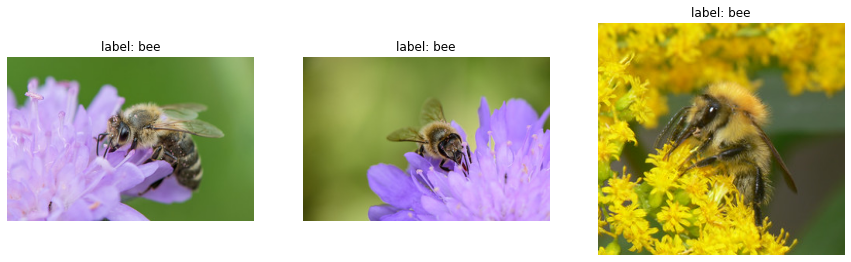

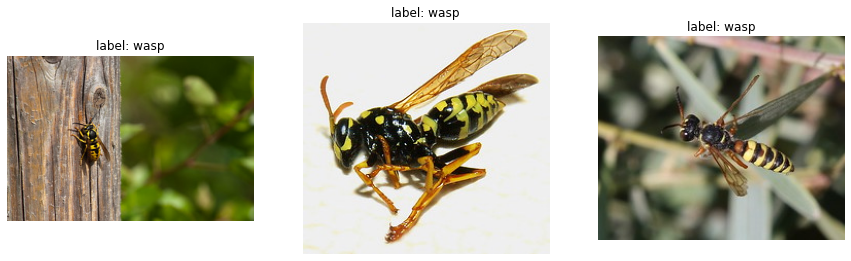

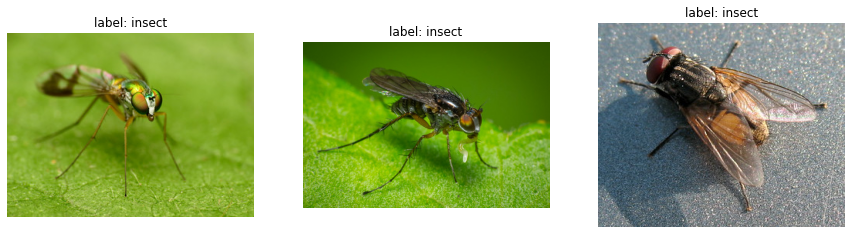

In [43]:

def img_plot(df, label):
    df = df.query('label == @label')
    imgs = []
    for path in df['path'][:3]:
        img = cv2.imread(ROOT+"/"+path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
    f, ax = plt.subplots(1,3, figsize=(15,15))
    for i, img in enumerate(imgs):
        ax[i%3].imshow(img)
        ax[i%3].axis('off')
        ax[i%3].set_title('label: %s' % label)
    plt.show()
    


img_plot(df_labels, label='bee')
img_plot(df_labels, label='wasp')
img_plot(df_labels, label='insect')

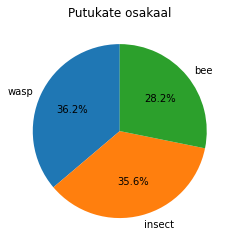

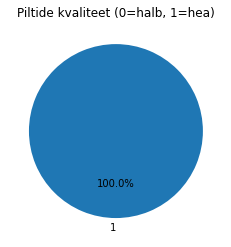

In [51]:
labels = list(df_labels['label'].unique())
y = list(df_labels['label'].value_counts())
plt.pie(y, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Putukate osakaal')
plt.show()

#kontroll
labels = list(df_labels['photo_quality'].unique())
y = list(df_labels['photo_quality'].value_counts())
plt.pie(y, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Piltide kvaliteet (0=halb, 1=hea)')

plt.show()

## Närvivõrgu loomine ja treenimine

In [ ]:
#Närvivõrk
def make_model(img_size, n):
    inp = Input(shape=(img_size,img_size,n))
    x = Conv2D(32, (3,3))(inp)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, (3,3))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inp, outputs=x) 
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

callback = tf.keras.callbacks.EarlyStopping(patience=10, 
                                               verbose=1, 
                                               restore_best_weights=True)
model = make_model(IMG_SIZE, 3)

In [ ]:
model.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
dense_75 (Dense)             (None, 256, 256, 64)      256       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 254, 254, 32)      18464     
_________________________________________________________________
activation_35 (Activation)   (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
dense_76 (Dense)             (None, 127, 127, 64)      2112      
_________________________________________________________________
activation_36 (Activation)   (None, 127, 127, 64)      0  

In [ ]:
print(train_imgs.shape)
print(train_df.shape)
print(train_df)

(509, 256, 256, 3)
(509, 3)
     bee  insect  wasp
0      1       0     0
1      0       0     1
2      0       0     1
3      0       1     0
4      0       0     1
..   ...     ...   ...
504    1       0     0
505    1       0     0
506    0       1     0
507    1       0     0
508    0       0     1

[509 rows x 3 columns]


In [ ]:
#Mudeli treenimine
history = model.fit(train_imgs, 
                    train_df, 
                    batch_size=bs, 
                    epochs=EPOCHS,
                    callbacks=[callback],
                    validation_data=(val_imgs, val_df)
                   )

Epoch 1/50
8/8 [==============================] - 3s 200ms/step - loss: 14.2771 - categorical_accuracy: 0.3249 - val_loss: 1.0654 - val_categorical_accuracy: 0.3833
Epoch 2/50
8/8 [==============================] - 1s 82ms/step - loss: 1.0793 - categorical_accuracy: 0.4748 - val_loss: 1.0266 - val_categorical_accuracy: 0.5417
Epoch 3/50
8/8 [==============================] - 1s 83ms/step - loss: 1.0027 - categorical_accuracy: 0.5233 - val_loss: 1.0100 - val_categorical_accuracy: 0.5083
Epoch 4/50
8/8 [==============================] - 1s 77ms/step - loss: 0.8724 - categorical_accuracy: 0.6128 - val_loss: 1.2355 - val_categorical_accuracy: 0.3667
Epoch 5/50
8/8 [==============================] - 1s 77ms/step - loss: 0.9859 - categorical_accuracy: 0.5363 - val_loss: 0.9357 - val_categorical_accuracy: 0.6417
Epoch 6/50
8/8 [==============================] - 1s 79ms/step - loss: 0.7737 - categorical_accuracy: 0.7092 - val_loss: 1.0362 - val_categorical_accuracy: 0.4333
Epoch 7/50
8/8 [====

## Testimine

In [ ]:
#Test hulgal täpsus
model.evaluate(test_imgs, test_df) 

4/4 [==============================] - 0s 21ms/step - loss: 0.9696 - categorical_accuracy: 0.6040


[0.9695920348167419, 0.603960394859314]

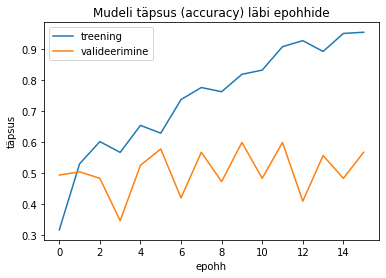

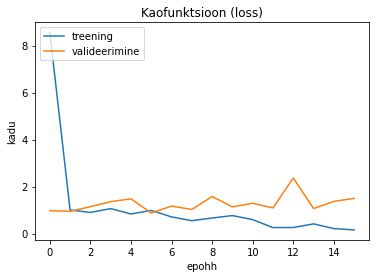

In [53]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Mudeli täpsus (accuracy) läbi epohhide')
plt.ylabel('täpsus')
plt.xlabel('epohh')
plt.legend(['treening', 'valideerimine'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Kaofunktsioon (loss)')
plt.ylabel('kadu')
plt.xlabel('epohh')
plt.legend(['treening', 'valideerimine'], loc='upper left')
plt.show()